# Prepare functions

# Setup

In [1]:
import sys
sys.path.insert(1, '/users/genomics/xoel/canonades/bioinforgalician/src/python/celloracle')

In [2]:
import os

subset = 'Gliogenesis'
os.chdir(f'/users/genomics/xoel/codebases/co_new/data/{subset}/')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [3]:
import scanpy as sc
sc.set_figure_params(
    scanpy=True,
    dpi=80, 
    dpi_save=300, 
    frameon=True,
    vector_friendly=True, 
    fontsize=14, 
    figsize=None, 
    color_map=None,
    facecolor=None, 
    transparent=False, 
    ipython_format='png2x')
sc.settings.verbosity=4
sc.settings.autosave=True
sc.settings.autoshow=True

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [4]:
n_cores = min(int(os.getenv('SLURM_CPUS_PER_TASK')) -4 or 18, 96)


# **Part 1 //** Create a gene regulatory network (GRN)

## Find ATAC coaccessible peaks

In [6]:
from cicero_helper import create_cicero_cmd

In [7]:
os.listdir()

['RNA.unprocessed.h5ad',
 'ATAC.cell_metadata.tsv',
 'cicero_umap.pdf',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'base_grn.coaccessibility=0.8.score=8.base_grn',
 'cicero.log',
 'ATAC.peak_metadata.tsv',
 'cicero_connections.rds',
 'ATAC.unprocessed.tsv',
 'cicero_peaks.csv',
 'cicero_connections.csv',
 'figures',
 'Rplots.pdf',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'old']

In [5]:
r_cmd = create_cicero_cmd( 
    atac_path='ATAC.unprocessed.tsv',
    peaks_bed_path='ATAC.peak_metadata.tsv',
    cell_metadata_path='ATAC.cell_metadata.tsv', 
    plot_by='cell.type', 
    R_quote='',
    str_quote="\'",
    save_dir='./', 
    prefix=None, 
    verbose='TRUE')

with open('temp_cicero.sh', 'wt') as f:
    f.writelines(r_cmd)
print(r_cmd)

source('/users/genomics/xoel/canonades/bioinforgalician/src/python/celloracle/cicero.R',echo=TRUE)

pipe_cicero_conns(atac_path='ATAC.unprocessed.tsv',peaks_bed_path='ATAC.peak_metadata.tsv',cell_metadata_path='ATAC.cell_metadata.tsv',plot_by='cell.type',save_dir='./',prefix=NULL,verbose=TRUE)


In [6]:
%%bash -s "$r_cmd" "$subset"
eval "$(micromamba shell hook --shell=bash)"
micromamba activate ~/venvs/cicero
# LOCAL
# Rscript --vanilla --verbose ./temp_cicero.sh
# sbatch --job-name=$2 --output=cicero.log --mem=185GB --time=4-00:00:00 --partition=normal,long,bigmem --cpus-per-task=20 --wrap="Rscript --vanilla --verbose ./temp_cicero.sh"

In [7]:
# !while [ 1 ]; do tail cicero.log sleep 30; clear; done
!cat cicero.log | grep -v 'chr1' |  tail -20

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.644033328333738
Median shared cells bin-bin: 0
[2] Running cicero analysis
[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Successful cicero models:  9590"
[1] "Other models: "

  Too many elements in range Zero or one element in range 
                        1122                         2388 
[1] "Models with errors:  0"
[1] "Done"
[SAVE] Saving connections & peaks
                          Peak1                     Peak2      coaccess
 [ reached 'max' / getOption("max.print") -- omitted 101228863 rows ]


In [8]:
!rm ./temp_cicero.sh

## Run motif analysis and filter

In [8]:
import cicero_to_grn 

Adding to PATH: /soft/system/software/BEDTools/2.30.0-GCC-10.2.0/bin


In [10]:
os.listdir()

['RNA.unprocessed.h5ad',
 'ATAC.cell_metadata.tsv',
 'cicero_umap.pdf',
 'log.test.txt',
 'ATAC.peak_metadata.tsv',
 'cicero_connections.rds',
 'ATAC.unprocessed.tsv',
 'cicero_peaks.csv',
 'cicero_connections.csv',
 'Rplots.pdf']

In [12]:
grn_result = cicero_to_grn.run_motif_analysis(
    peaks_csv='cicero_peaks.csv',
    connections_csv='cicero_connections.csv',
    
    extra_peaks=None,
    ref_genome='hg38',
    provider='UCSC',
    frp=0.02,
    coacc_thres=0.8,
    motifs=None,
    motif_score_thres=8,
    save_dir='./',
    prefix=None,
    verbose=True
)

[1] Loading peaks and connections
[2] Loading genome
hg38 is installed.
[3] Integrating peaks, connections and genome
que bed peaks: 648442
tss peaks in que: 44640
[4] Filtering peaks by coaccessibility (0.8)
Over threshold: 2.19 %
[5] Extracting peaks
[6] Performing motif scan (frp: 0.02)
No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 

Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



scanning:   0%|          | 0/40183 [00:00<?, ? sequences/s]

[7] Filtering motif score (motif_score_thres)
Over threshold: 49.65 %
Filtering finished: 11144861 -> 4122521
1. Converting scanned results into one-hot encoded dataframe.


  0%|          | 0/40183 [00:00<?, ?it/s]

2. Converting results into dictionaries.


  0%|          | 0/20004 [00:00<?, ?it/s]

  0%|          | 0/1098 [00:00<?, ?it/s]

[8] Saving results


  0%|          | 0/3 [00:00<?, ?it/s]

# **Part 2 //** Prepare RNA data

In [19]:
import importlib
prepare_rna = importlib.reload(prepare_rna)

In [9]:
import scanpy as sc
import prepare_rna
%matplotlib inline

In [10]:
sorted(os.listdir())

['ATAC.cell_metadata.tsv',
 'ATAC.peak_metadata.tsv',
 'ATAC.unprocessed.tsv',
 'RNA.unprocessed.h5ad',
 'Rplots.pdf',
 'base_grn.coaccessibility=0.8.score=8.base_grn',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cicero.log',
 'cicero_connections.csv',
 'cicero_connections.rds',
 'cicero_peaks.csv',
 'cicero_umap.pdf',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'figures',
 'old']

In [11]:
adata_file = 'RNA.unprocessed.h5ad'
adata_complete = sc.read_h5ad(adata_file)

In [16]:
dict(
    RGCmaturationExtended = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    RGCmaturation = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    NeuralPCW16 = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    Gliogenesis = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    GliogenesisExtended = 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
)

{'RGCmaturationExtended': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC',
 'RGCmaturation': 'hft_w16_p7_r2_TGGAGAGAGAGGACTC'}

### PIPE [1] PREPROCESSING DATA


  0%|          | 0/8 [00:00<?, ?it/s]

[1] Saving raw counts
[2] Computing QC
[3] Filtering genes: total_counts > 1
[4] Normalizing per cell using total_counts
normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'total_counts', counts per cell before normalization (adata.obs)
[5] Computing highly variable genes and filtering to top 3000
(8366, 17465)
extracting highly variable genes
    the 3000 top genes correspond to a normalized dispersion cutoff of 1.611411452293396
    finished (0:00:00)


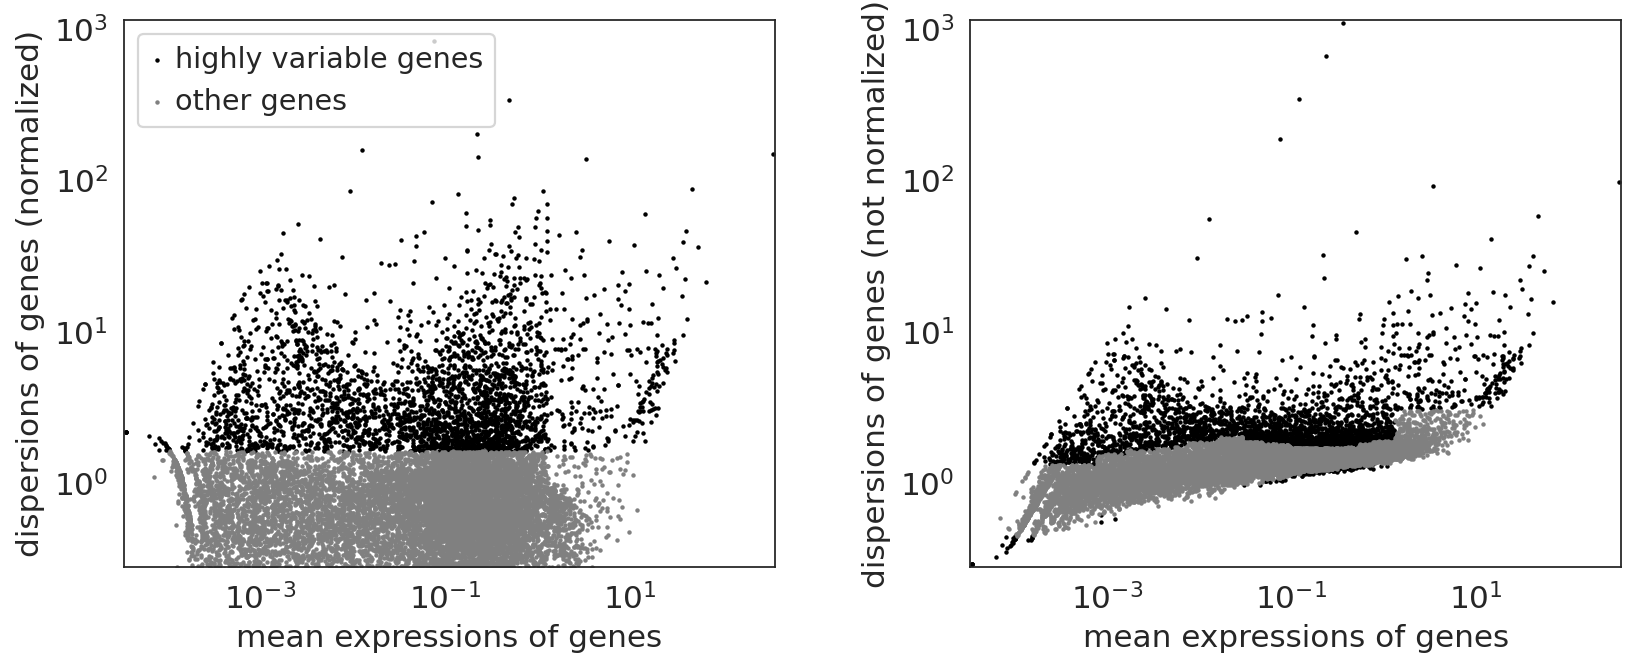

(8366, 3000)
[6] Normalizing per cell again using total_counts
normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'total_counts', counts per cell before normalization (adata.obs)
[7] Log1p transformation
[8] Scaling
### PIPE [2] EMBEDDING DATA


  0%|          | 0/8 [00:00<?, ?it/s]

[1] Computing PCA
computing PCA
    with n_comps=50
    finished (0:00:02)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


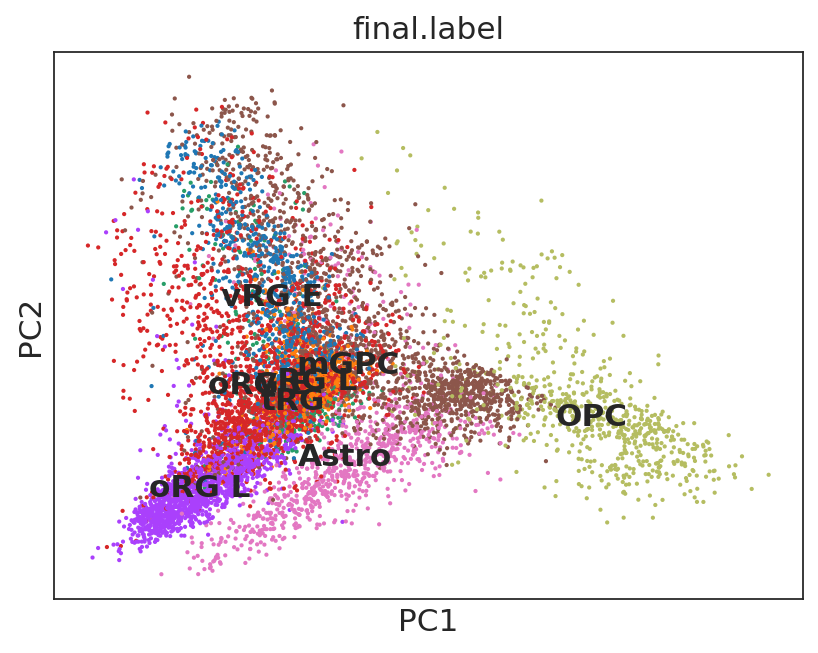

[2] Computing neighbors
computing neighbors
    computing neighbors
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
[3] Computing diffusion map
computing Diffusion Maps using n_comps=20(=n_dcs)
        initialized `.distances` `.connectivities` 
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9958282  0.9914993  0.98790777 0.98615855 0.9806449
     0.97668815 0.97395986 0.9666071  0.9644341  0.9619223  0.96052206
     0.959179   0.95661527 0.9527829  0.94942266 0.9439083  0.94143045
     0.9398606  0.938552  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
[4] Computing neighbors in diffusion map
computing neighbors
        initialized `.distanc

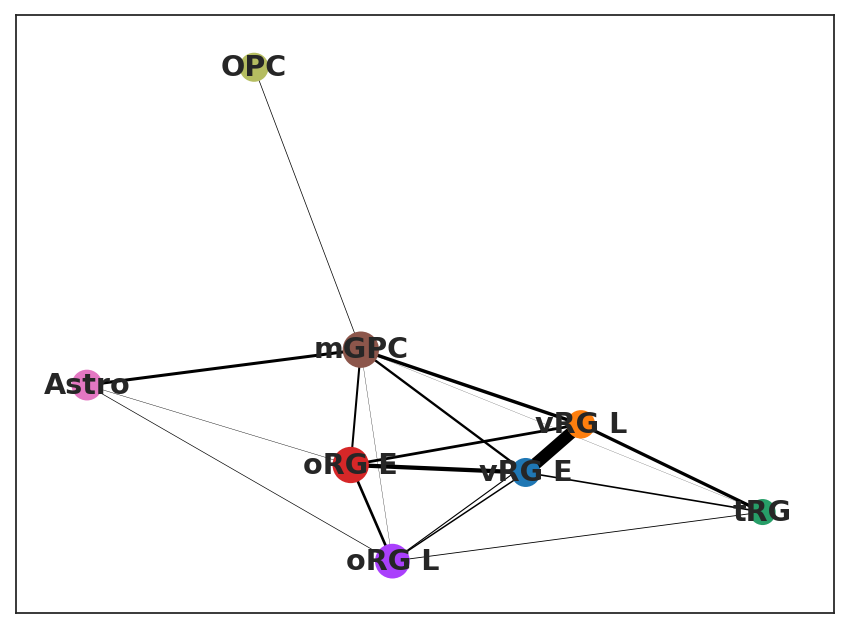

[7] Constructing PAGA graph (2/2)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:54)


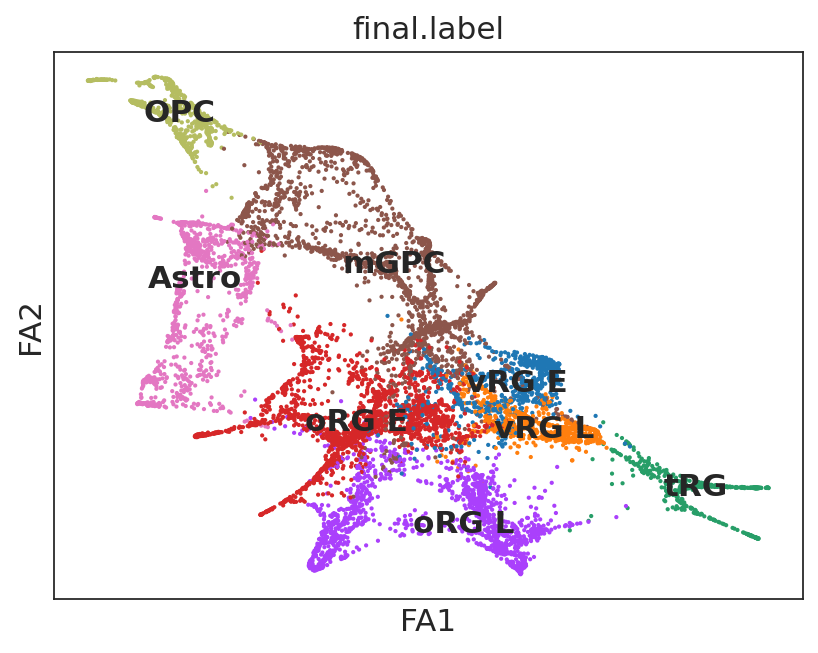

[8] Constructing PHATE graph
X_scvi
Running on X_scvi obsm
Calculating PHATE...
  Running PHATE on 8366 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 2.28 seconds.
    Calculating affinities...
    Calculated affinities in 0.51 seconds.
  Calculated graph and diffusion operator in 2.89 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.45 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.75 seconds.
  Calculated landmark operator in 9.36 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.12 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.58 seconds.
Calculated PHATE in 16.96 seconds.


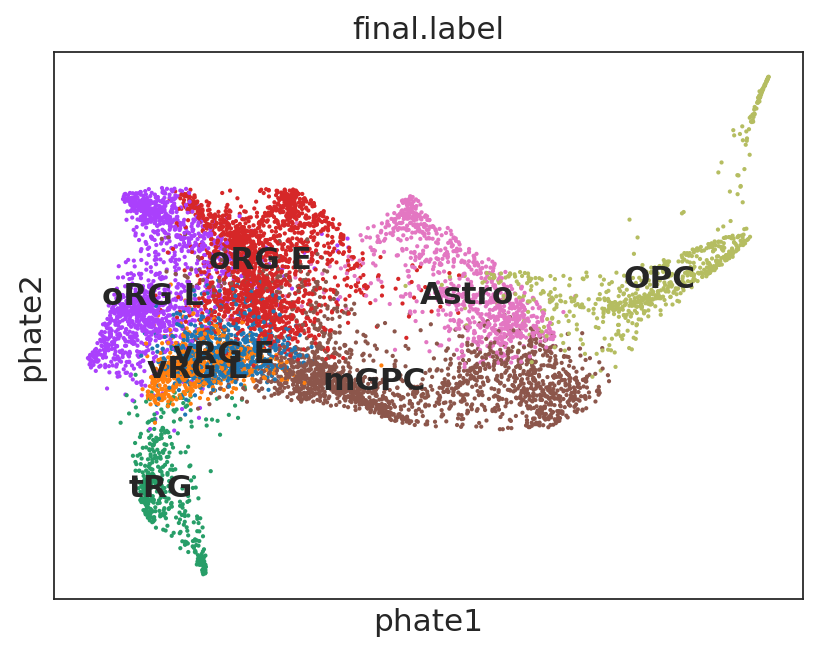

### PIPE [3] COMPUTING PSEUDOTIME


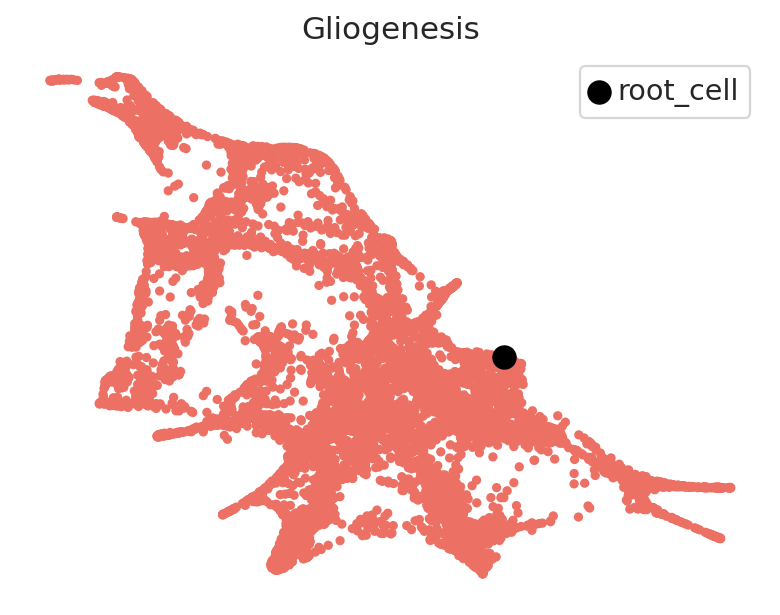

        initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


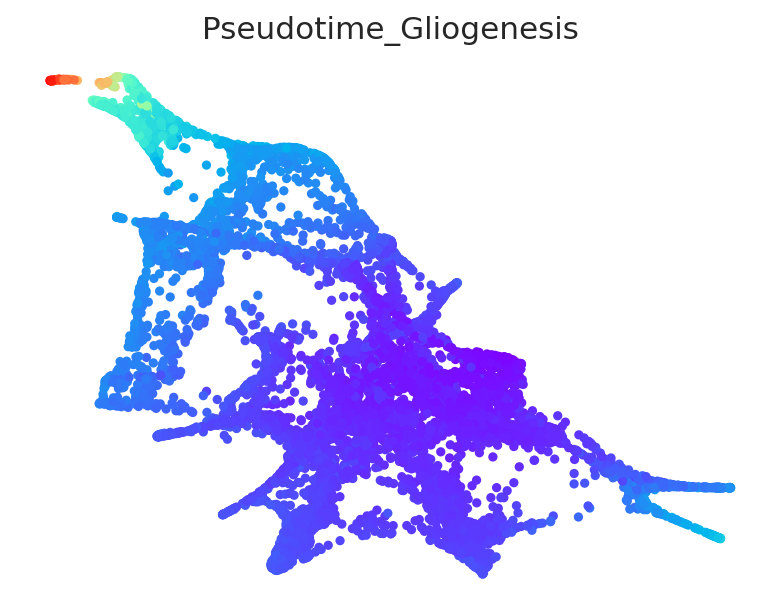

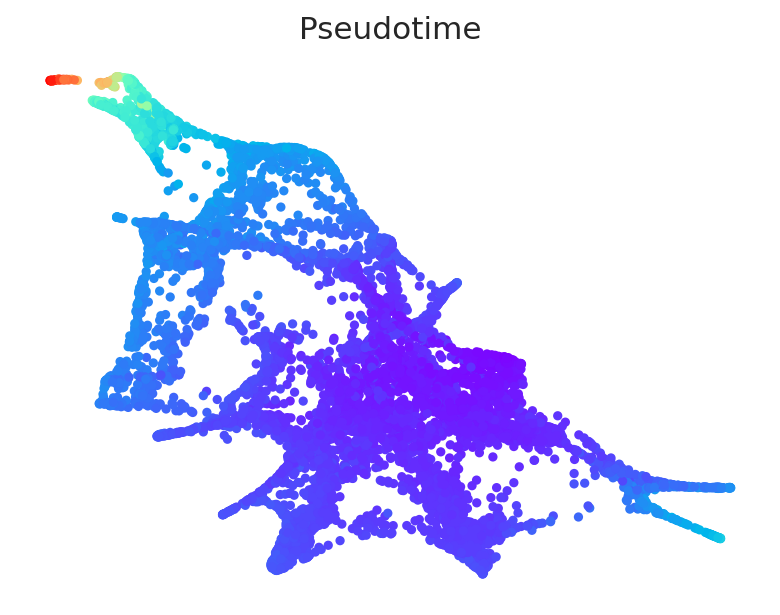

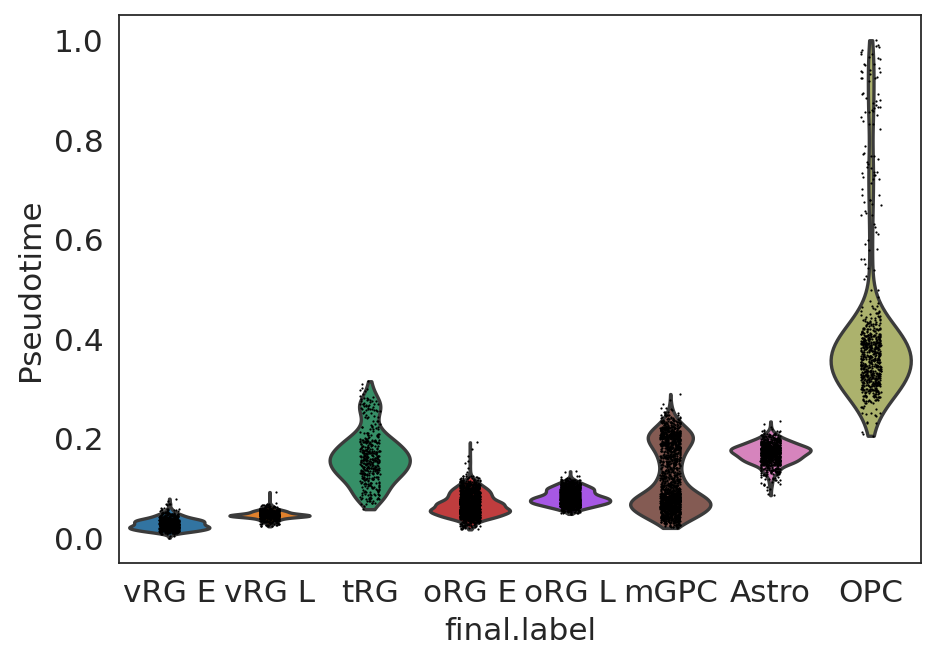

### PIPE [4] SAVING DATA


In [42]:
adata = prepare_rna.prepare_adata(
    
    adata_complete,
    group_by='final.label',
    save_dir='./',
    # save_dir=None,

    
    min_total_counts_per_cell=1,
    key_n_counts='total_counts',
    n_top_genes=3000,

    nn_1_n_neighbors=10,
    nn_1_use_rep='X_scvi',
    nn_1_n_pcs=10,
    dm_n_comps=20,
    nn_2_n_neighbors=50,

    phate_run_on='X_scvi',
    phate_t=5,
    phate_knn=60,
    phate_decay=10,
    phate_n_pca=None,
    
    skip_paga=False,
    skip_umap=False,
    skip_phate=False,
    random_state=None,    

    root_cells='hft_w16_p7_r2_TGGAGAGAGAGGACTC',
    lineages=None, 
    lineage_name=subset,
    embedding_key='X_draw_graph_fa',
    verbose=True)

# **Part 3 //** Fit GRN to expression

In [40]:
import network_fit

In [41]:
sorted(os.listdir())

['ATAC.cell_metadata.tsv',
 'ATAC.peak_metadata.tsv',
 'ATAC.unprocessed.tsv',
 'RNA.unprocessed.h5ad',
 'Rplots.pdf',
 'base_grn.coaccessibility=0.8.score=8.base_grn',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cicero.log',
 'cicero_connections.csv',
 'cicero_connections.rds',
 'cicero_peaks.csv',
 'cicero_umap.pdf',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'figures',
 'old']

In [45]:
oracle, links = network_fit.network_fit_pipe(
    adata_fname = 'RNA.processed.h5ad',
    base_GRN_fname = 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
    cluster_column_name = 'final.label',
    max_n_pcs = 50,
    links_alpha=10,
    links_pval=0.001,
    links_top_n_coef=2000,
    # seed = 4,
    verbose = True,
    save_dir='./',
    test_mode=False)

  0%|          | 0/7 [00:00<?, ?it/s]

[1] Reading data
Loading adata
Loading GRN
- Excluding None
[2] Prepairing oracle object


  0%|          | 0/4 [00:00<?, ?it/s]

[1] Instatiating Oracle with raw RNA-Seq data
    Expression range: count     8366.000000
mean      3882.266357
std       2235.004150
min        256.000000
25%       2422.000000
50%       3480.000000
75%       5035.750000
max      30622.000000
dtype: float64
[2] Adding GRN data to Oracle
[3] Computing and selecting PCs and k for neighbors
[4] Computing KNNs:
    n cells: 8366
    k: 209
    oracle.knn_imputation(n_pca_dims=n_comps, k=209, balanced=True, b_sight=1672, b_maxl=836, n_jobs=-1)
Oracle object

Meta data
    celloracle version used for instantiation: 0.12.0
    n_cells: 8366
    n_genes: 3000
    cluster_name: final.label
    dimensional_reduction_name: X_draw_graph_fa
    n_target_genes_in_TFdict: 20004 genes
    n_regulatory_in_TFdict: 1098 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 160 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 2655 genes
    k_for_knn_imputation: 209
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
 

  0%|          | 0/8 [00:00<?, ?it/s]

Inferring GRN for Astro...


  0%|          | 0/2655 [00:00<?, ?it/s]

Inferring GRN for OPC...


  0%|          | 0/2655 [00:00<?, ?it/s]

Inferring GRN for mGPC...


  0%|          | 0/2655 [00:00<?, ?it/s]

Inferring GRN for oRG E...


  0%|          | 0/2655 [00:00<?, ?it/s]

Inferring GRN for oRG L...


  0%|          | 0/2655 [00:00<?, ?it/s]

Inferring GRN for tRG...


  0%|          | 0/2655 [00:00<?, ?it/s]

Inferring GRN for vRG E...


  0%|          | 0/2655 [00:00<?, ?it/s]

Inferring GRN for vRG L...


  0%|          | 0/2655 [00:00<?, ?it/s]

[4] Checking links
All fits are valid.
[5] Postprocessing links
[6] Scoring genes


  0%|          | 0/8 [00:00<?, ?it/s]

/scratch/xoel/tmp/6/25/scratch/xoel/tmp/6/73/scratch/xoel/tmp/6/2/scratch/xoel/tmp/6/70/scratch/xoel/tmp/6/52/scratch/xoel/tmp/6/62/scratch/xoel/tmp/6/75/scratch/xoel/tmp/6/91







/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R



Attaching package: ‘igraph’


Attaching package: ‘igraph’


Attaching package: ‘igraph’


Attaching package: ‘igraph’
Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:
The following objects are masked from ‘package:stats’:



The following objects are masked from ‘package:stats’:

The following objects are masked from ‘package:stats’:
The following objects are masked from ‘package:stats’:
    decompose, spectrum
    decompose, spectrum





    decompose, spectrum
    decompose, spectrum
    decompose, spectrum
The following object is masked from ‘package:base’:
The following object is masked from ‘package:base’:




The following object is masked from ‘package:base’:

The following object is masked from ‘package:base’:
The following object is masked from ‘package:base’:
    union




    union

    union
    union
    union

Attaching package: ‘igraph’





The following objects are masked from ‘package:stats’:
Attaching package: ‘igraph’
Attaching p

[7] Saving results
- Saving raw links per cluster


  0%|          | 0/8 [00:00<?, ?it/s]

- Saving filtered links per cluster


  0%|          | 0/8 [00:00<?, ?it/s]

- Saving processed links
- Saving oracle


In [47]:
%matplotlib Agg
network_fit.pipe_plots(links)

  0%|          | 0/5 [00:00<?, ?it/s]

Astro
OPC
mGPC
oRG E
oRG L
tRG
vRG E
vRG L


  0%|          | 0/8 [00:00<?, ?it/s]

degree_centrality_all
eigenvector_centrality


  0%|          | 0/3 [00:00<?, ?it/s]

Genes in filtered network: 807


  0%|          | 0/807 [00:00<?, ?it/s]

ABCC9
ACAP3
ACAT2
ACSBG1
ACTB
ACTG1
ACTR3B
ADD3
ADGRV1
AGT
AHCYL1
AHRR
ALDOC
AMOTL2
ANKRD9
ANXA1
ANXA2
APCDD1
APLP1
APOD
APOE
AQP4
ARC
ARHGAP11A
ARID5B
ARL4A
ARL4C
ARL6IP1
ASCL1
ASF1B
ASPM
ASRGL1
ATAD2
ATCAY
ATF3
ATP1A2
ATP1B2
ATP1B3
AURKA
AURKB
B2M
B3GAT2
BAALC
BACH2
BARD1
BASP1
BATF3
BCAN
BCAS1
BCHE
BCL11A
BCL11B
BCL3
BHLHE41
BIRC5
BNIP3
BRCA1
BRCA2
BRIP1
BTBD17
BTG1
BTG2
BUB1
BUB1B
BUB3
C11orf96
C12orf75
C1QL1
C1QL2
C21orf58
C2orf69
C3orf70
C8orf76
C9orf24
CA12
CA2
CA3
CADM2
CALM1
CALM2
CAMSAP2
CARHSP1
CASP3
CCDC146
CCDC170
CCDC34
CCDC80
CCL2
CCN1
CCN2
CCNA1
CCNA2
CCNB1
CCNB2
CCND1
CCND2
CCNE2
CCNF
CCNL1
CCNT2
CD38
CD9
CDC20
CDC25B
CDCA2
CDCA3
CDCA4
CDCA5
CDCA7
CDCA8
CDK1
CDK6
CDKN1C
CDKN2C
CDKN2D
CDKN3
CDO1
CDT1
CEBPB
CEBPD
CENPA
CENPB
CENPE
CENPF
CENPH
CENPK
CENPM
CENPN
CENPU
CENPW
CEP126
CEP135
CEP55
CEP70
CFAP126
CHAF1A
CHEK1
CHST11
CKAP2
CKAP2L
CKAP5
CKB
CKS2
CLDN10
CLSPN
CLU
CNIH2
CNN3
CNP
CNTLN
COL11A1
COL20A1
COL9A1
COLGALT2
CPE
CRB1
CRH
CROT
CRYAB
CRYM
CSPG5
CSRP2
CST3
CTNN

  0%|          | 0/807 [00:00<?, ?it/s]

()

# **Part 4 //** Perturbation analysis

In [6]:
import perturbations

In [6]:
sorted(os.listdir())

['ATAC.cell_metadata.tsv',
 'ATAC.peak_metadata.tsv',
 'ATAC.unprocessed.tsv',
 'Gradient.Perturbation.celloracle.gradient',
 'Links.Perturbation.celloracle.links',
 'Links.celloracle.links',
 'Oracle.Perturbation.celloracle.oracle',
 'Oracle.celloracle.oracle',
 'RNA.processed.h5ad',
 'RNA.unprocessed.h5ad',
 'Rplots.pdf',
 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cicero.log',
 'cicero_connections.csv',
 'cicero_connections.rds',
 'cicero_peaks.csv',
 'cicero_umap.pdf',
 'cluster_GRN',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'figures',
 'network_plots',
 'old',
 'perturbations']

In [25]:
oracle, links, gradient = perturbations.prepare_data(
    oracle_fname='./Oracle.celloracle.oracle', 
    links_fname='./Links.celloracle.links',
    
    palette = None,
    group_by = None,
    
    grn_fit_ridge_alpha = 10,
    
    p_mass_smooth = 0.8,
    p_mass_n_grid = 40,
    p_mass_n_neighbors = 200,
    p_mass_filter_min = 0.0017,   

    method='knn',
    n_knn=200,
    n_poly=3,
    scale_dev = 40,
    s=5,
    
    # save_dir=None,
    save_dir='./',
    prefix=None,
    verbose=True)

  0%|          | 0/7 [00:00<?, ?it/s]

[1] Loading data
[2] Re-filtering links
[3] Getting TF dict
[4] Fitting for simulation


  0%|          | 0/8 [00:00<?, ?it/s]

[5] Computing grid p_mass
[6] Transferring pseudotime to grid
KNN pseudotime-transfer model
Polynomial pseudotime-transfer model


Select method [ knn | polynomial ] knn


KNN pseudotime-transfer model
[7] Saving data
	Links
	Oracle
	Gradient


In [7]:
groups = {
    'vRG': ['vRG E', 'vRG L'],
    'vtRG': ['vRG E', 'vRG L', 'tRG'],
    'oRG': ['oRG E', 'oRG L'],
    'RG E': ['vRG E', 'vRG E'],
    'RG L': ['vRG E', 'vRG L'],
    'RGC': ['vRG E','vRG L','tRG','oRG E','oRG L'],
    'Glial': ['mGPC', 'Astro', 'OPC'],
    'Diff Glia': ['Astro', 'OPC']
}

### KO simulation

In [ ]:
ps_sums = perturbations.run_systemic_simulation_async(
    oracle, gradient, groups=groups, 
    # genes=['FOXP1', 'MEF2C', 'KLF6', 'SIN3A'],
    n_cores=n_cores, n_parallel_genes=1, overwrite=True,
    p_mass_smooth = 0.8,
    p_mass_n_grid = 40,
    p_mass_n_neighbors = 200,
    p_mass_filter_min = 0.0017
)

Excluding: []
Selected number of neighbors: 200


  0%|          | 0/158 [00:00<?, ?it/s]

perturbation_hdf5/KO.AHRR.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation


### Carlo genes

In [21]:
oracle = perturbations.co.load_hdf5('Oracle.Perturbation.celloracle.oracle')
gradient = perturbations.co.load_hdf5('Gradient.Perturbation.celloracle.gradient')

In [22]:
carlo_genes = perturbations.pd.read_csv('~/codebases/co_new/raw/carlo_genes_pattern_12.csv')['Gene'].unique().tolist()

carlo_tfs = [c for c in carlo_genes if c in oracle.active_regulatory_genes]
carlo_in = [c for c in carlo_genes if c in oracle.adata.var_names]

In [23]:
carlo_dict = perturbations.pd.read_csv('~/codebases/co_new/raw/carlo_genes_pattern_12.csv').groupby('Top/Bottom')['Gene'].unique().to_dict()

carlo_tfs_dict = {k:[c for c in v if c in oracle.active_regulatory_genes] for k, v in carlo_dict.items()}
carlo_in_dict = {k:[c for c in v if c in oracle.adata.var_names] for k, v in carlo_dict.items()}

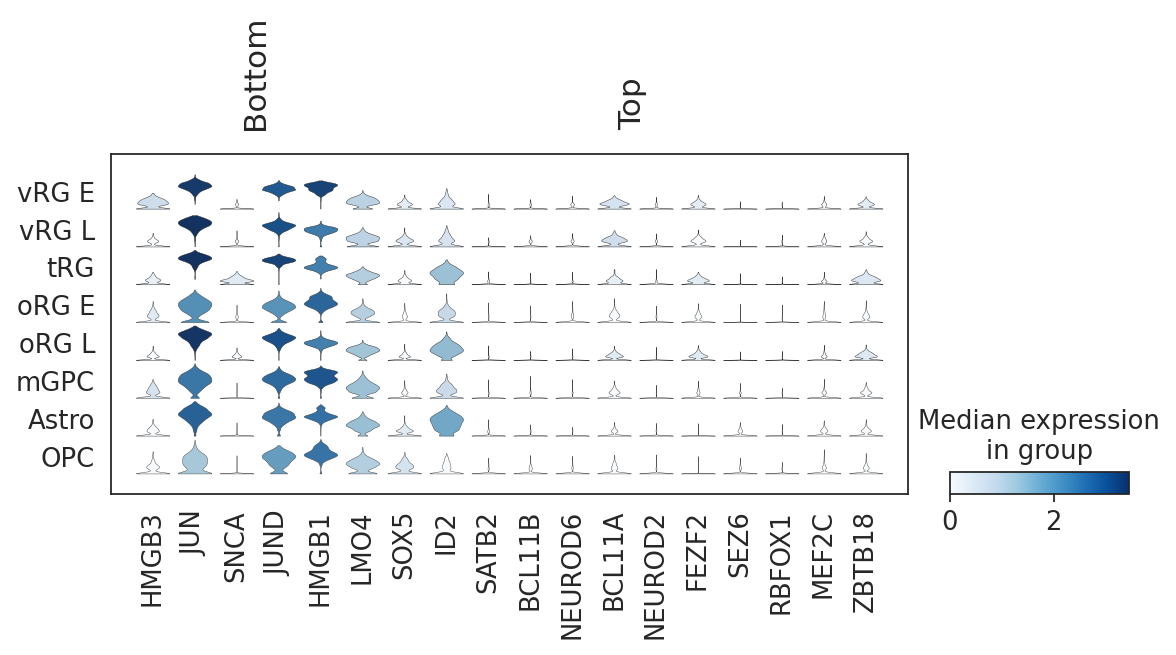

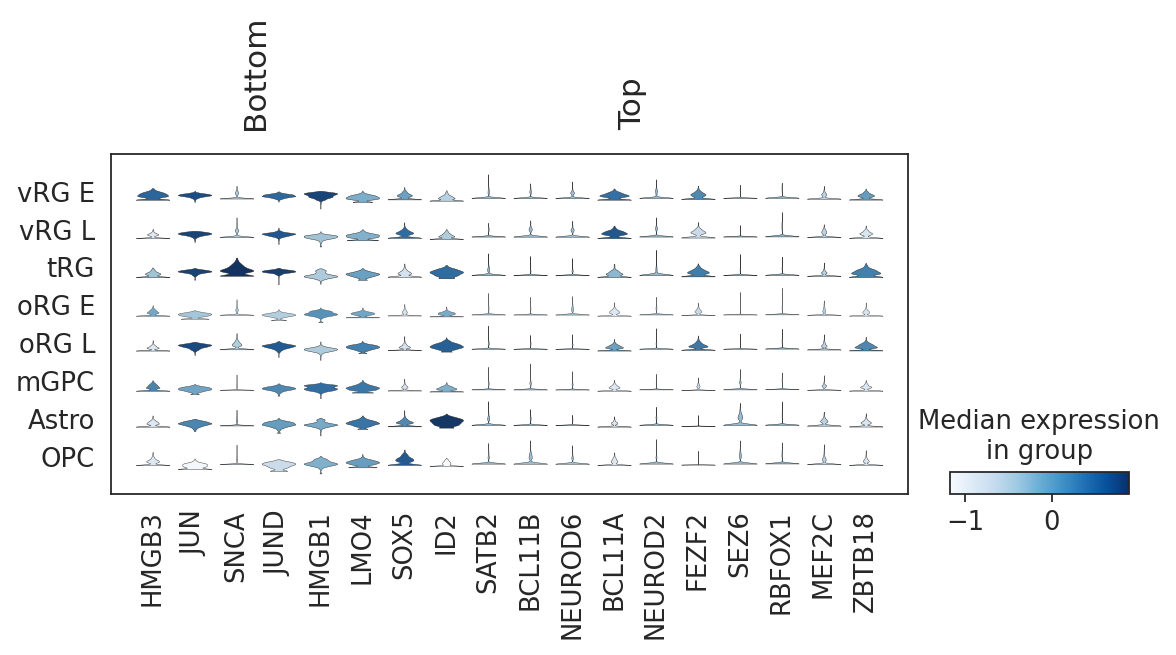

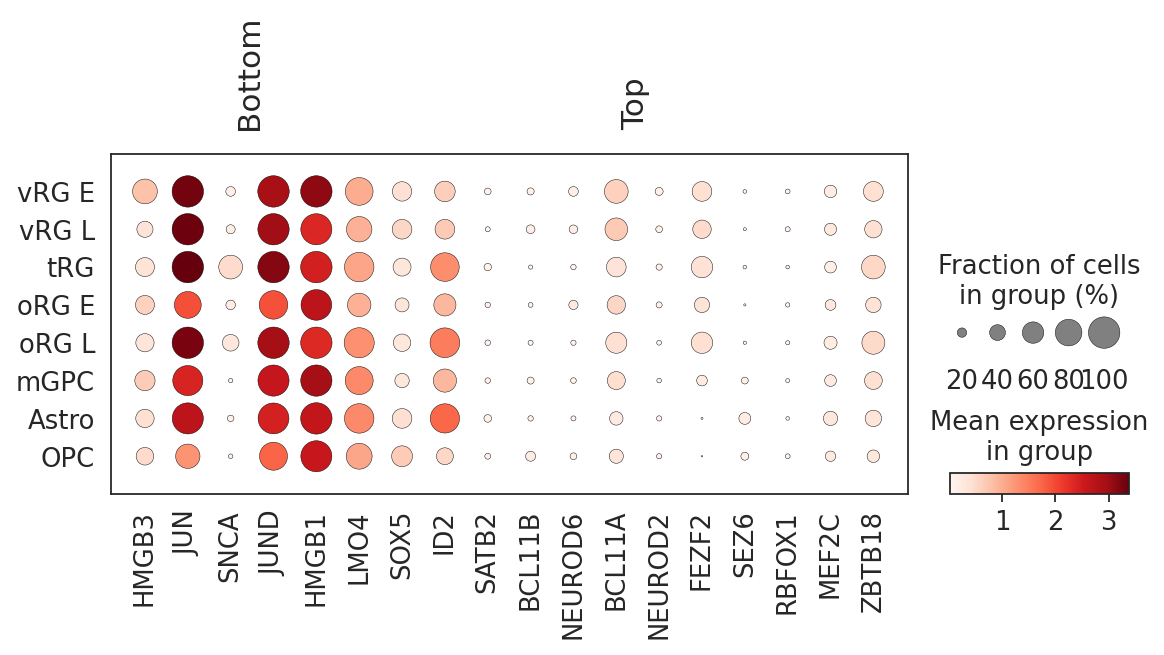

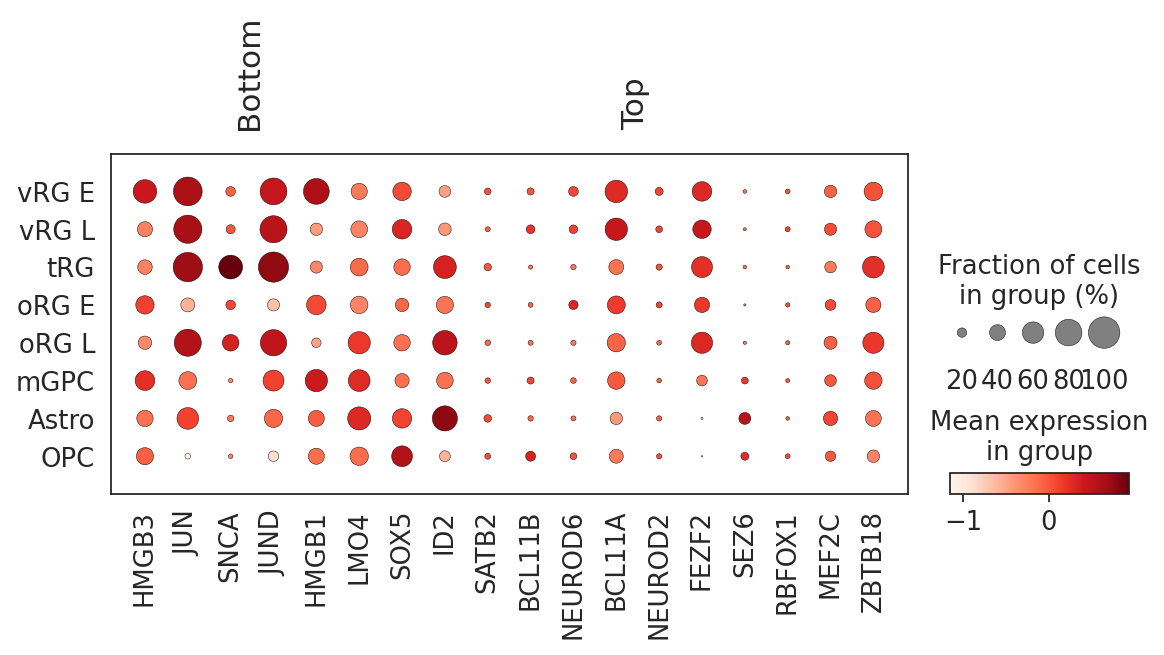

In [24]:
%matplotlib inline 
perturbations.sc.pl.stacked_violin(oracle.adata,
                                   var_names=carlo_in_dict,
                                   layer='log1p',
                                   groupby='final.label',
                                   save='carlo_genes_log1p')
%matplotlib inline 
perturbations.sc.pl.stacked_violin(oracle.adata,
                                   var_names=carlo_in_dict,
                                   layer='scaled',
                                   groupby='final.label',
                                   save='carlo_genes_scaled')
perturbations.sc.pl.dotplot(oracle.adata,
                                   var_names=carlo_in_dict,
                                   layer='log1p',
                                   groupby='final.label',
                                   save='carlo_genes_log1p')
%matplotlib inline 
perturbations.sc.pl.dotplot(oracle.adata,
                                   var_names=carlo_in_dict,
                                   layer='scaled',
                                   groupby='final.label',
                                   save='carlo_genes_scaled')

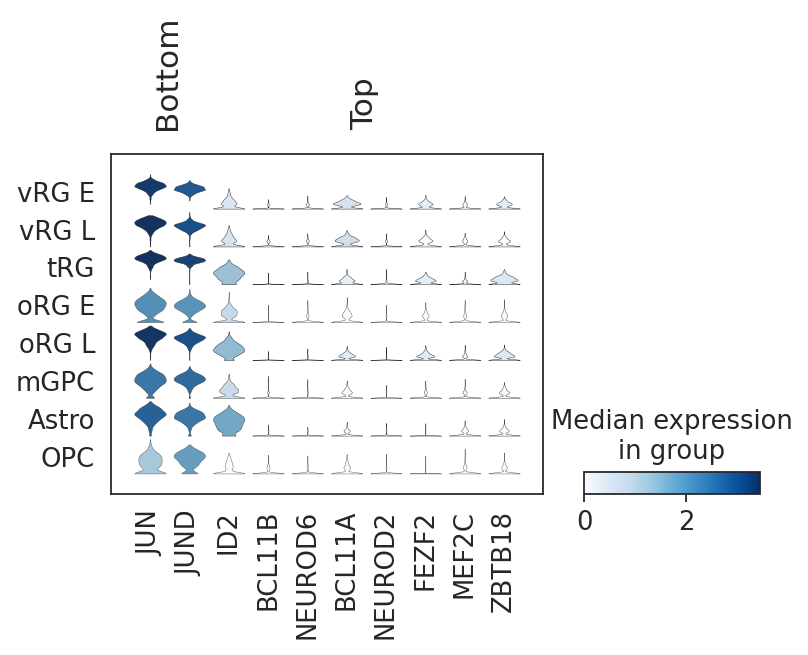

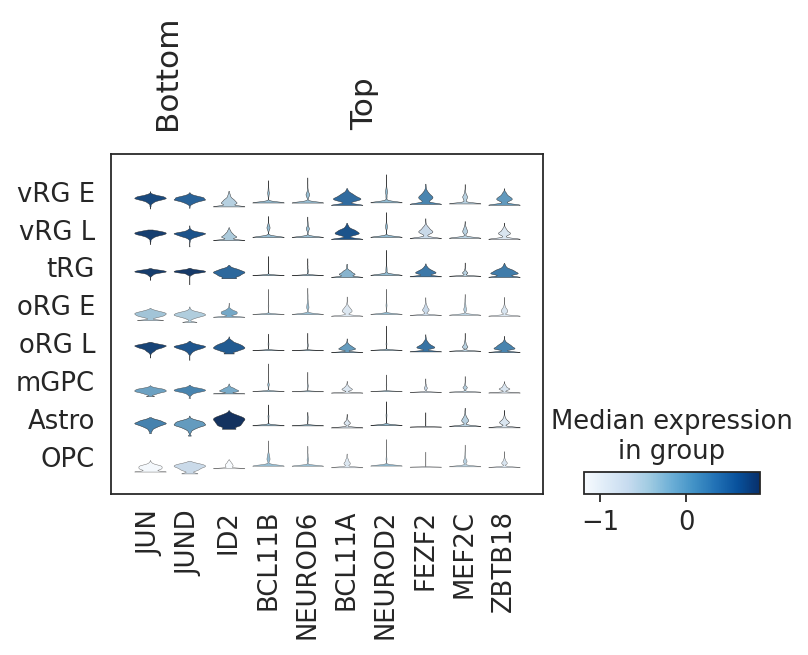

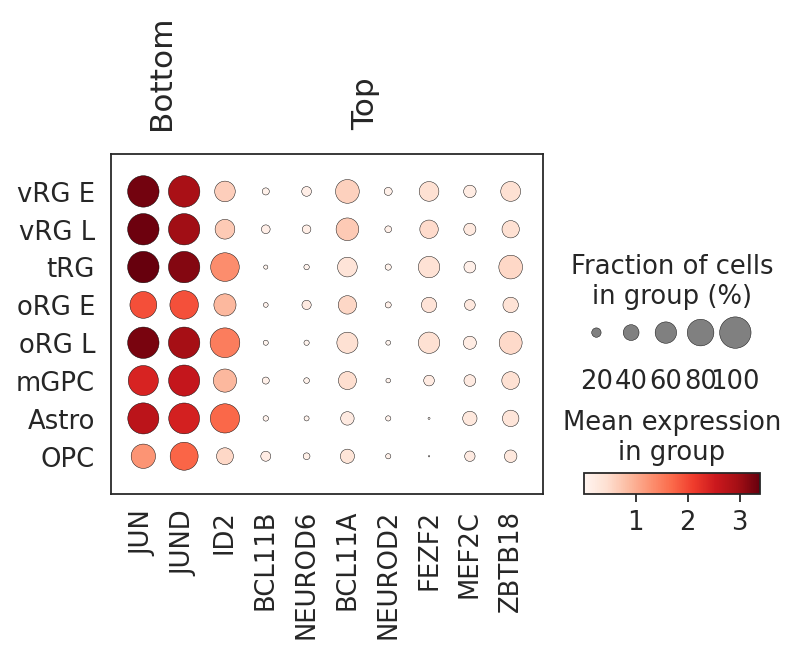

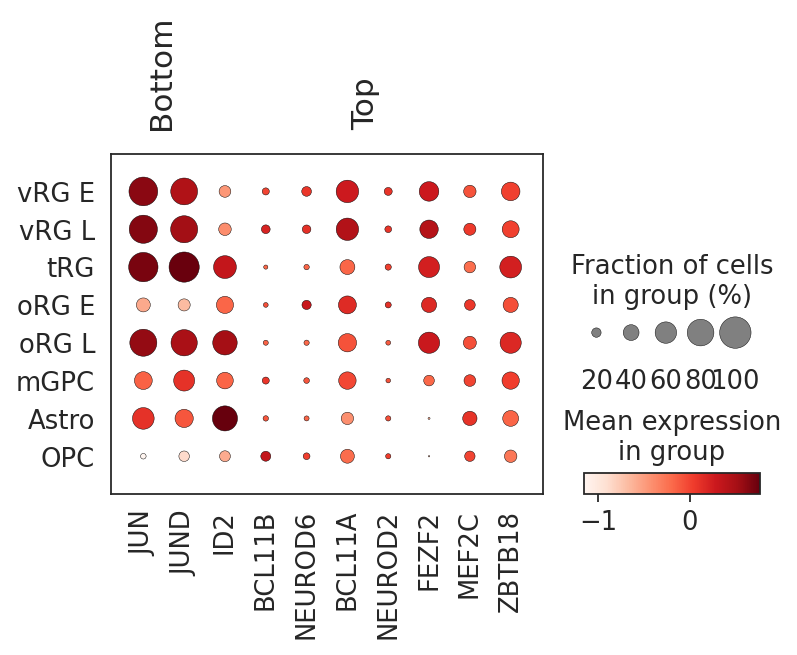

In [25]:
%matplotlib inline 
perturbations.sc.pl.stacked_violin(oracle.adata,
                                   var_names=carlo_tfs_dict,
                                   layer='log1p',
                                   groupby='final.label',
                                   save='carlo_tfs_log1p')
%matplotlib inline 
perturbations.sc.pl.stacked_violin(oracle.adata,
                                   var_names=carlo_tfs_dict,
                                   layer='scaled',
                                   groupby='final.label',
                                   save='carlo_tfs_scaled')
perturbations.sc.pl.dotplot(oracle.adata,
                                   var_names=carlo_tfs_dict,
                                   layer='log1p',
                                   groupby='final.label',
                                   save='carlo_tfs_log1p')
%matplotlib inline 
perturbations.sc.pl.dotplot(oracle.adata,
                                   var_names=carlo_tfs_dict,
                                   layer='scaled',
                                   groupby='final.label',
                                   save='carlo_tfs_scaled')

In [45]:
{k: print('\|'.join(v)) for k, v in carlo_dict.items()}

HMGB3\|HMGN1\|POU3F3\|NEUROD1\|POU3F2\|BEX4\|TCF4\|JUN\|BEX3\|NFIX\|LHX2\|SNCA\|JUND\|HMGB1\|BEX1\|LMO4
SOX5\|ID2\|SATB2\|BCL11B\|NFIB\|NEUROD6\|BCL11A\|NEUROD2\|FEZF2\|SEZ6\|RBFOX1\|FOXG1\|AUTS2\|MEF2C\|ZBTB18


{'Bottom': None, 'Top': None}

In [37]:
{perturbations.sc.tl.score_genes(adata=oracle.adata, gene_list=v, score_name=f'score_{k}_in', use_raw=True) for k, v in carlo_in_dict.items()}

computing score 'score_Bottom_in'
    finished: added
    'score_Bottom_in', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)
computing score 'score_Top_in'
    finished: added
    'score_Top_in', score of gene set (adata.obs).
    399 total control genes are used. (0:00:00)


{None}

In [38]:
{perturbations.sc.tl.score_genes(adata=oracle.adata, gene_list=v, score_name=f'score_{k}_tf', use_raw=True, gene_pool=carlo_tfs) for k, v in carlo_tfs_dict.items()}

computing score 'score_Bottom_tf'
    finished: added
    'score_Bottom_tf', score of gene set (adata.obs).
    8 total control genes are used. (0:00:00)
computing score 'score_Top_tf'
    finished: added
    'score_Top_tf', score of gene set (adata.obs).
    2 total control genes are used. (0:00:00)


{None}

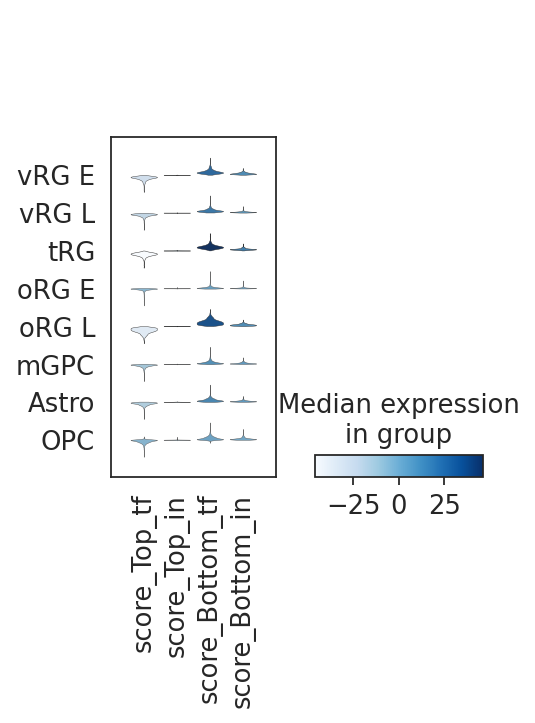

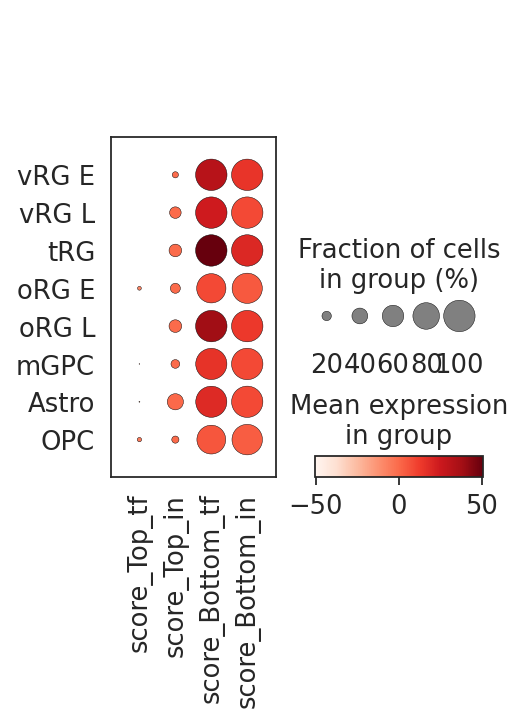

In [49]:
%matplotlib inline 
perturbations.sc.pl.stacked_violin(oracle.adata,
                                   var_names=[f'score_Top_tf',
                                              f'score_Top_in',
                                              f'score_Bottom_tf',
                                              f'score_Bottom_in'],
                                   # standard_scale='var',
                                   groupby='final.label',
                                   save='carlo_scores')
perturbations.sc.pl.dotplot(oracle.adata,
                            expression_cutoff=0,
                            
                                   var_names=[f'score_Top_tf',
                                              f'score_Top_in',
                                              f'score_Bottom_tf',
                                              f'score_Bottom_in'],
                                   # standard_scale='var',
                                   groupby='final.label',
                                   save='carlo_scores')

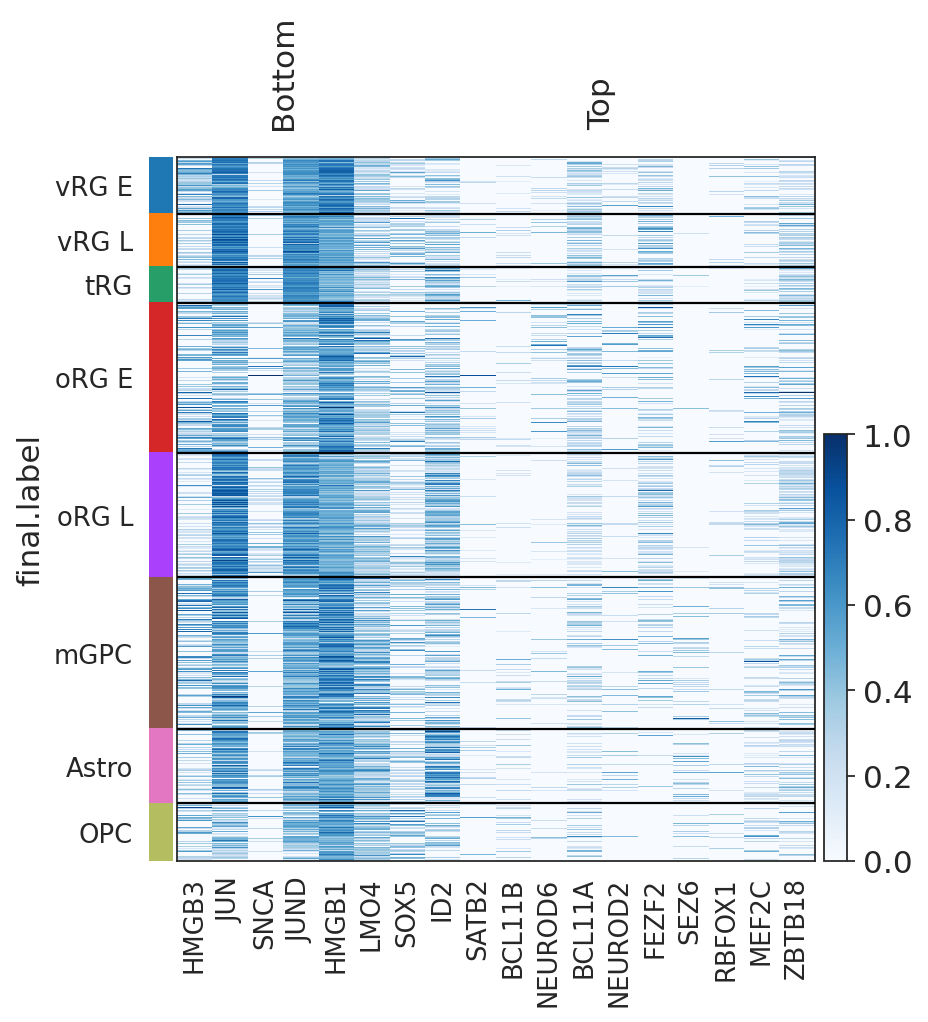

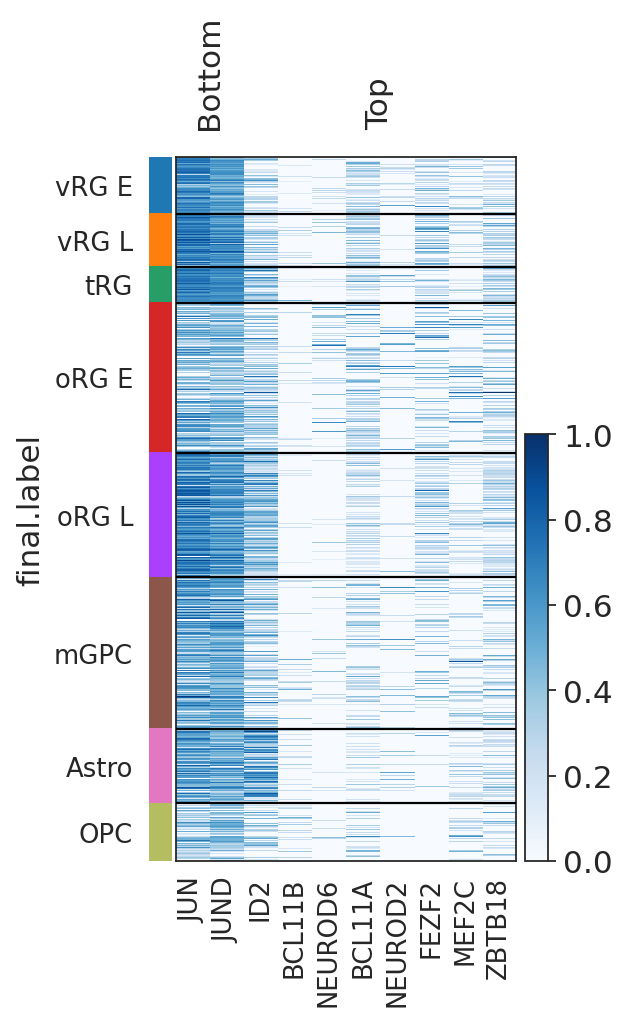

In [68]:
perturbations.sc.pl.heatmap(
    oracle.adata,

    # dendrogram=True,
    var_names=carlo_in_dict,
    standard_scale='var',
    layer='log1p',
    cmap=perturbations.sc.pl.palettes.cm.Blues,
    groupby='final.label',
    save='_carlo_genes'
)

perturbations.sc.pl.heatmap(
    oracle.adata,

    # dendrogram=True,
    var_names=carlo_tfs_dict,
    standard_scale='var',
    layer='log1p',
    cmap=perturbations.sc.pl.palettes.cm.Blues,
    groupby='final.label',
    save='_carlo_tfs'
)

# Explore

### Expression

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np

from scanpy.plotting._anndata import _prepare_dataframe

In [6]:
adata = sc.read_h5ad('RNA.processed.h5ad', backed=True)

/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


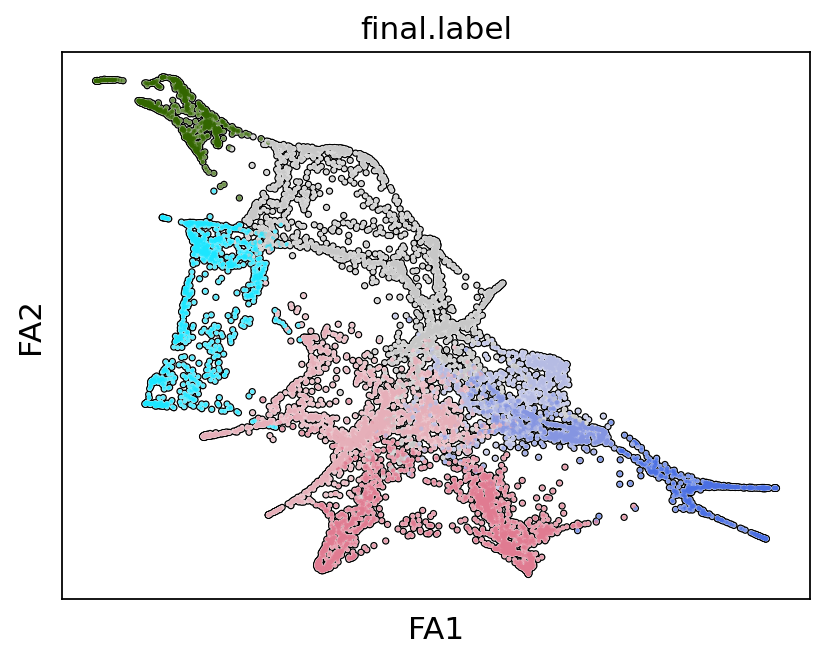

In [18]:
%matplotlib inline
p = sc.pl.draw_graph(adata, 
                 color='final.label',
                 palette={
                     
                     'vRG E': '#b5bbe3',
                     'vRG L': '#8595e1',
                     'tRG': '#4a6fe3',
                     'oRG E':  '#e6afb9',
                     'oRG L':  '#e07b91',
                     'mGPC':  '#c7c7c7',
                     'Astro':  '#1ce6ff',
                     'OPC': '#336600'},
                legend_loc=None,
                 return_fig=True,
                 size=15,
                add_outline=True)

p.savefig('figures/draw_graph_fa.png', )

In [ ]:
sc.pl.draw_graph()

In [19]:
pss = pd.read_csv('perturbations/KO.PerturbationScores.csv', index_col=0)
pss['log1p.score'] = np.log1p(pss['score'])
pss['rel_max.log1p.score'] = pss['log1p.score'] / pss.groupby('group')['log1p.score'].transform(np.max)
pss['q90'] = pss.groupby('group')['log1p.score'].transform(lambda x: x >= x.quantile(0.9))
all_genes = pss.gene.unique()
q90_genes = pss.gene[pss['q90']].unique()
q90_dict = pss[pss.q90].groupby('group')['gene'].unique().to_dict()
ct_q90_dict = {k:v  for k, v in q90_dict.items() if k in adata.obs['final.label'].cat.categories}
lin_q90_dict = {k:v  for k, v in q90_dict.items() if not k in adata.obs['final.label'].cat.categories and not 'not_' in k}

In [20]:
%matplotlib inline

sc.tl.dendrogram(adata, groupby='final.label', var_names=list(q90_genes)+['MEF2C'])

/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


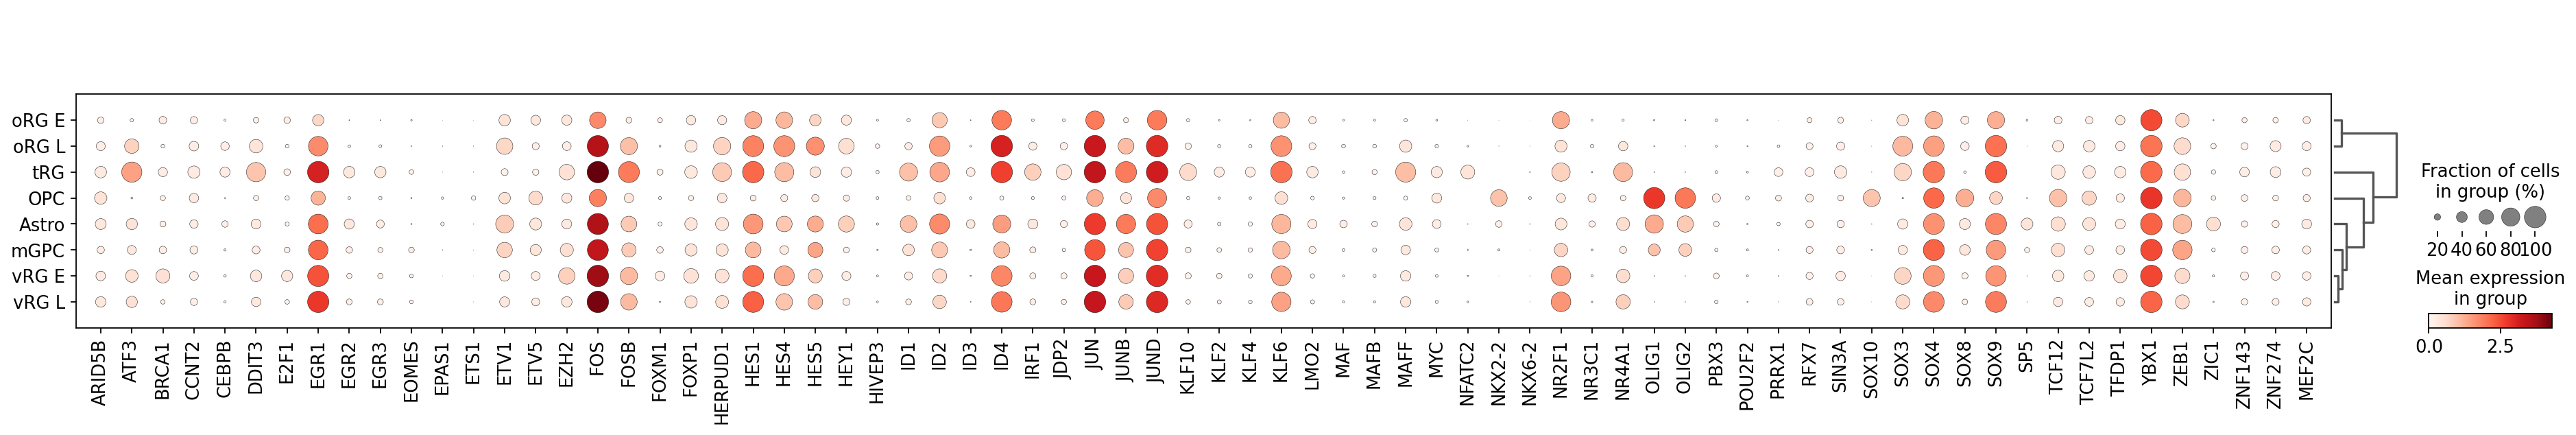

In [21]:
sc.pl.dotplot(adata, list(q90_genes)+['MEF2C'], 'final.label', layer='log1p', dendrogram=True)
# dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

In [9]:
sel = ['RGC', 'mGPC', 'Glial', 'OPC', 'Astro']
q90_sel = { k: v for k, v in q90_dict.items() if k in sel}

/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


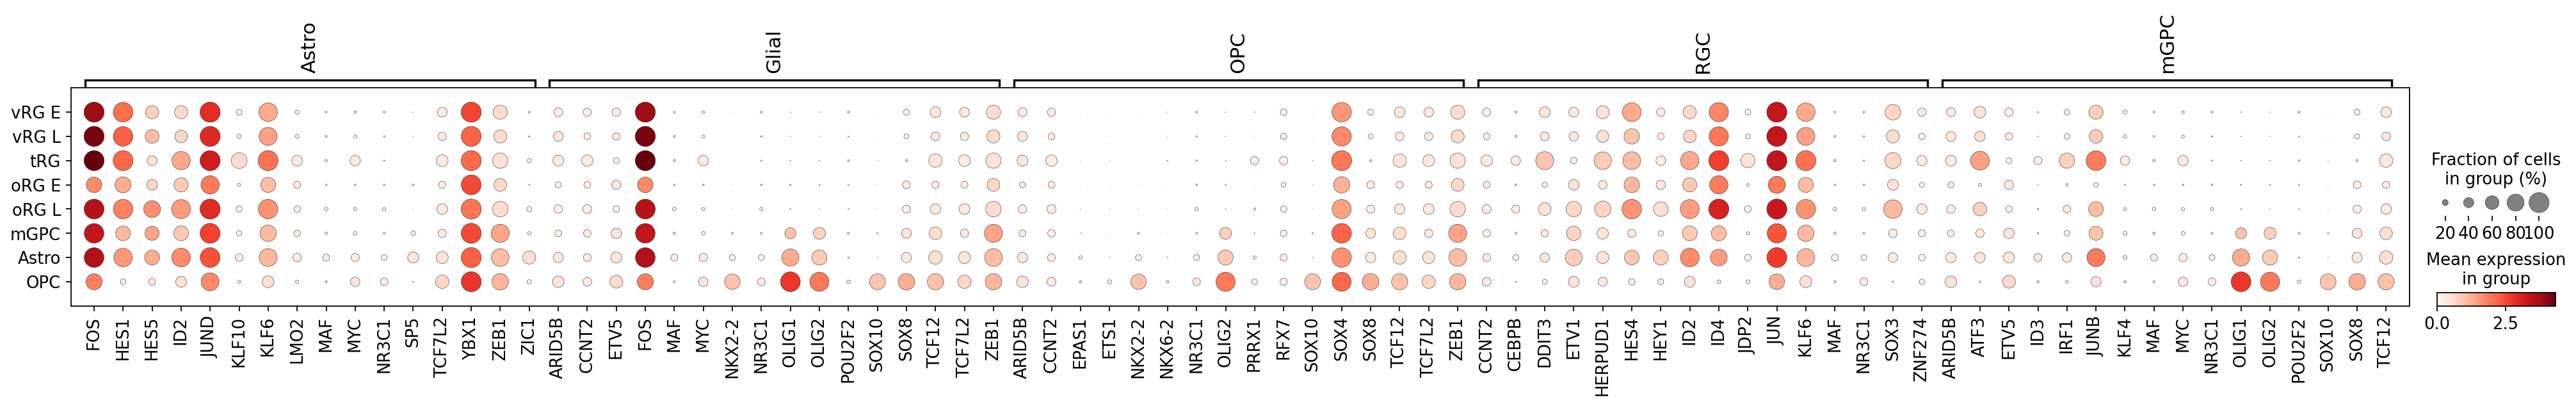

In [12]:
sc.pl.dotplot(adata, q90_sel, 'final.label', layer='log1p', dendrogram=False)

In [ ]:
sizes = (_prepare_dataframe(adata, var_names=all_genes, groupby='final.label', use_raw=True, log=False)[1]>0).groupby('final.label').mean().T

exps = _prepare_dataframe(adata, var_names=all_genes, groupby='final.label', use_raw=False, layer='log1p', log=False)[1].groupby('final.label').mean().T

for k in lin_q90_dict.keys():

     if k != 'Whole data':
        a = adata[adata.obs['final.label'].isin(groups[k]), all_genes]
        mean = _prepare_dataframe(adata, var_names=all_genes, groupby='final.label', use_raw=False, layer='log1p', log=False)[1].mean().T
        pct = (_prepare_dataframe(a, var_names=all_genes, groupby='final.label', use_raw=True, log=False)[1]>0).mean()
        exps[k] = mean
        sizes[k] = pct

In [ ]:
exps.to_csv('perturbations/KO.PerturbationScoreExpression.csv', index=True)
sizes.to_csv('perturbations/KO.PerturbationScoreExpressionPct.csv', index=True)

### Perturbation plots

In [18]:
%matplotlib inline

In [9]:
import celloracle as co
from celloracle.applications.systematic_analysis_helper import Oracle_systematic_analysis_helper, Oracle_development_module

In [10]:
gene = 'FOXP1'

In [11]:
helper = Oracle_systematic_analysis_helper(hdf5_file_path=f'perturbations/perturbation_hdf5/KO.{gene}.celloracle.hdf5')

In [12]:
gradient = co.load_hdf5('Gradient.Perturbation.celloracle.gradient')
oracle = co.load_hdf5('Oracle.Perturbation.celloracle.oracle')

In [13]:
helper.interactive_sort_TFs_by_neagative_ip()


interactive(children=(Dropdown(description='misc', options=('Astro', 'Diff Glia', 'Glial', 'OPC', 'RG E', 'RG …

In [14]:
oracle.simulate_shift(perturb_condition={gene: 0.0},)

In [15]:
# Make Oracle development module class to load data
file_path = f"perturbations/perturbation_hdf5/KO.{gene}.celloracle.hdf5"
dev = Oracle_development_module(gradient_object=gradient)
dev.set_hdf_path(path=file_path)
# If we use the function below, we can see information of the saved data
info = dev.get_hdf5_info()

print("Genes\n", info["gene_list"])

print("\nSimulation conditions\n", info["misc_list"])

Genes
 ['FOXP1']

Simulation conditions
 ['Astro' 'Diff Glia' 'Glial' 'OPC' 'RG E' 'RG L' 'RGC' 'Whole data' 'mGPC'
 'not_Astro' 'not_Diff Glia' 'not_Glial' 'not_OPC' 'not_RG E' 'not_RG L'
 'not_RGC' 'not_mGPC' 'not_oRG' 'not_oRG E' 'not_oRG L' 'not_tRG'
 'not_vRG' 'not_vRG E' 'not_vRG L' 'not_vtRG' 'oRG' 'oRG E' 'oRG L' 'tRG'
 'vRG' 'vRG E' 'vRG L' 'vtRG']


In [16]:
# Load one results
dev.load_hdf5(gene=gene, misc="Whole data")

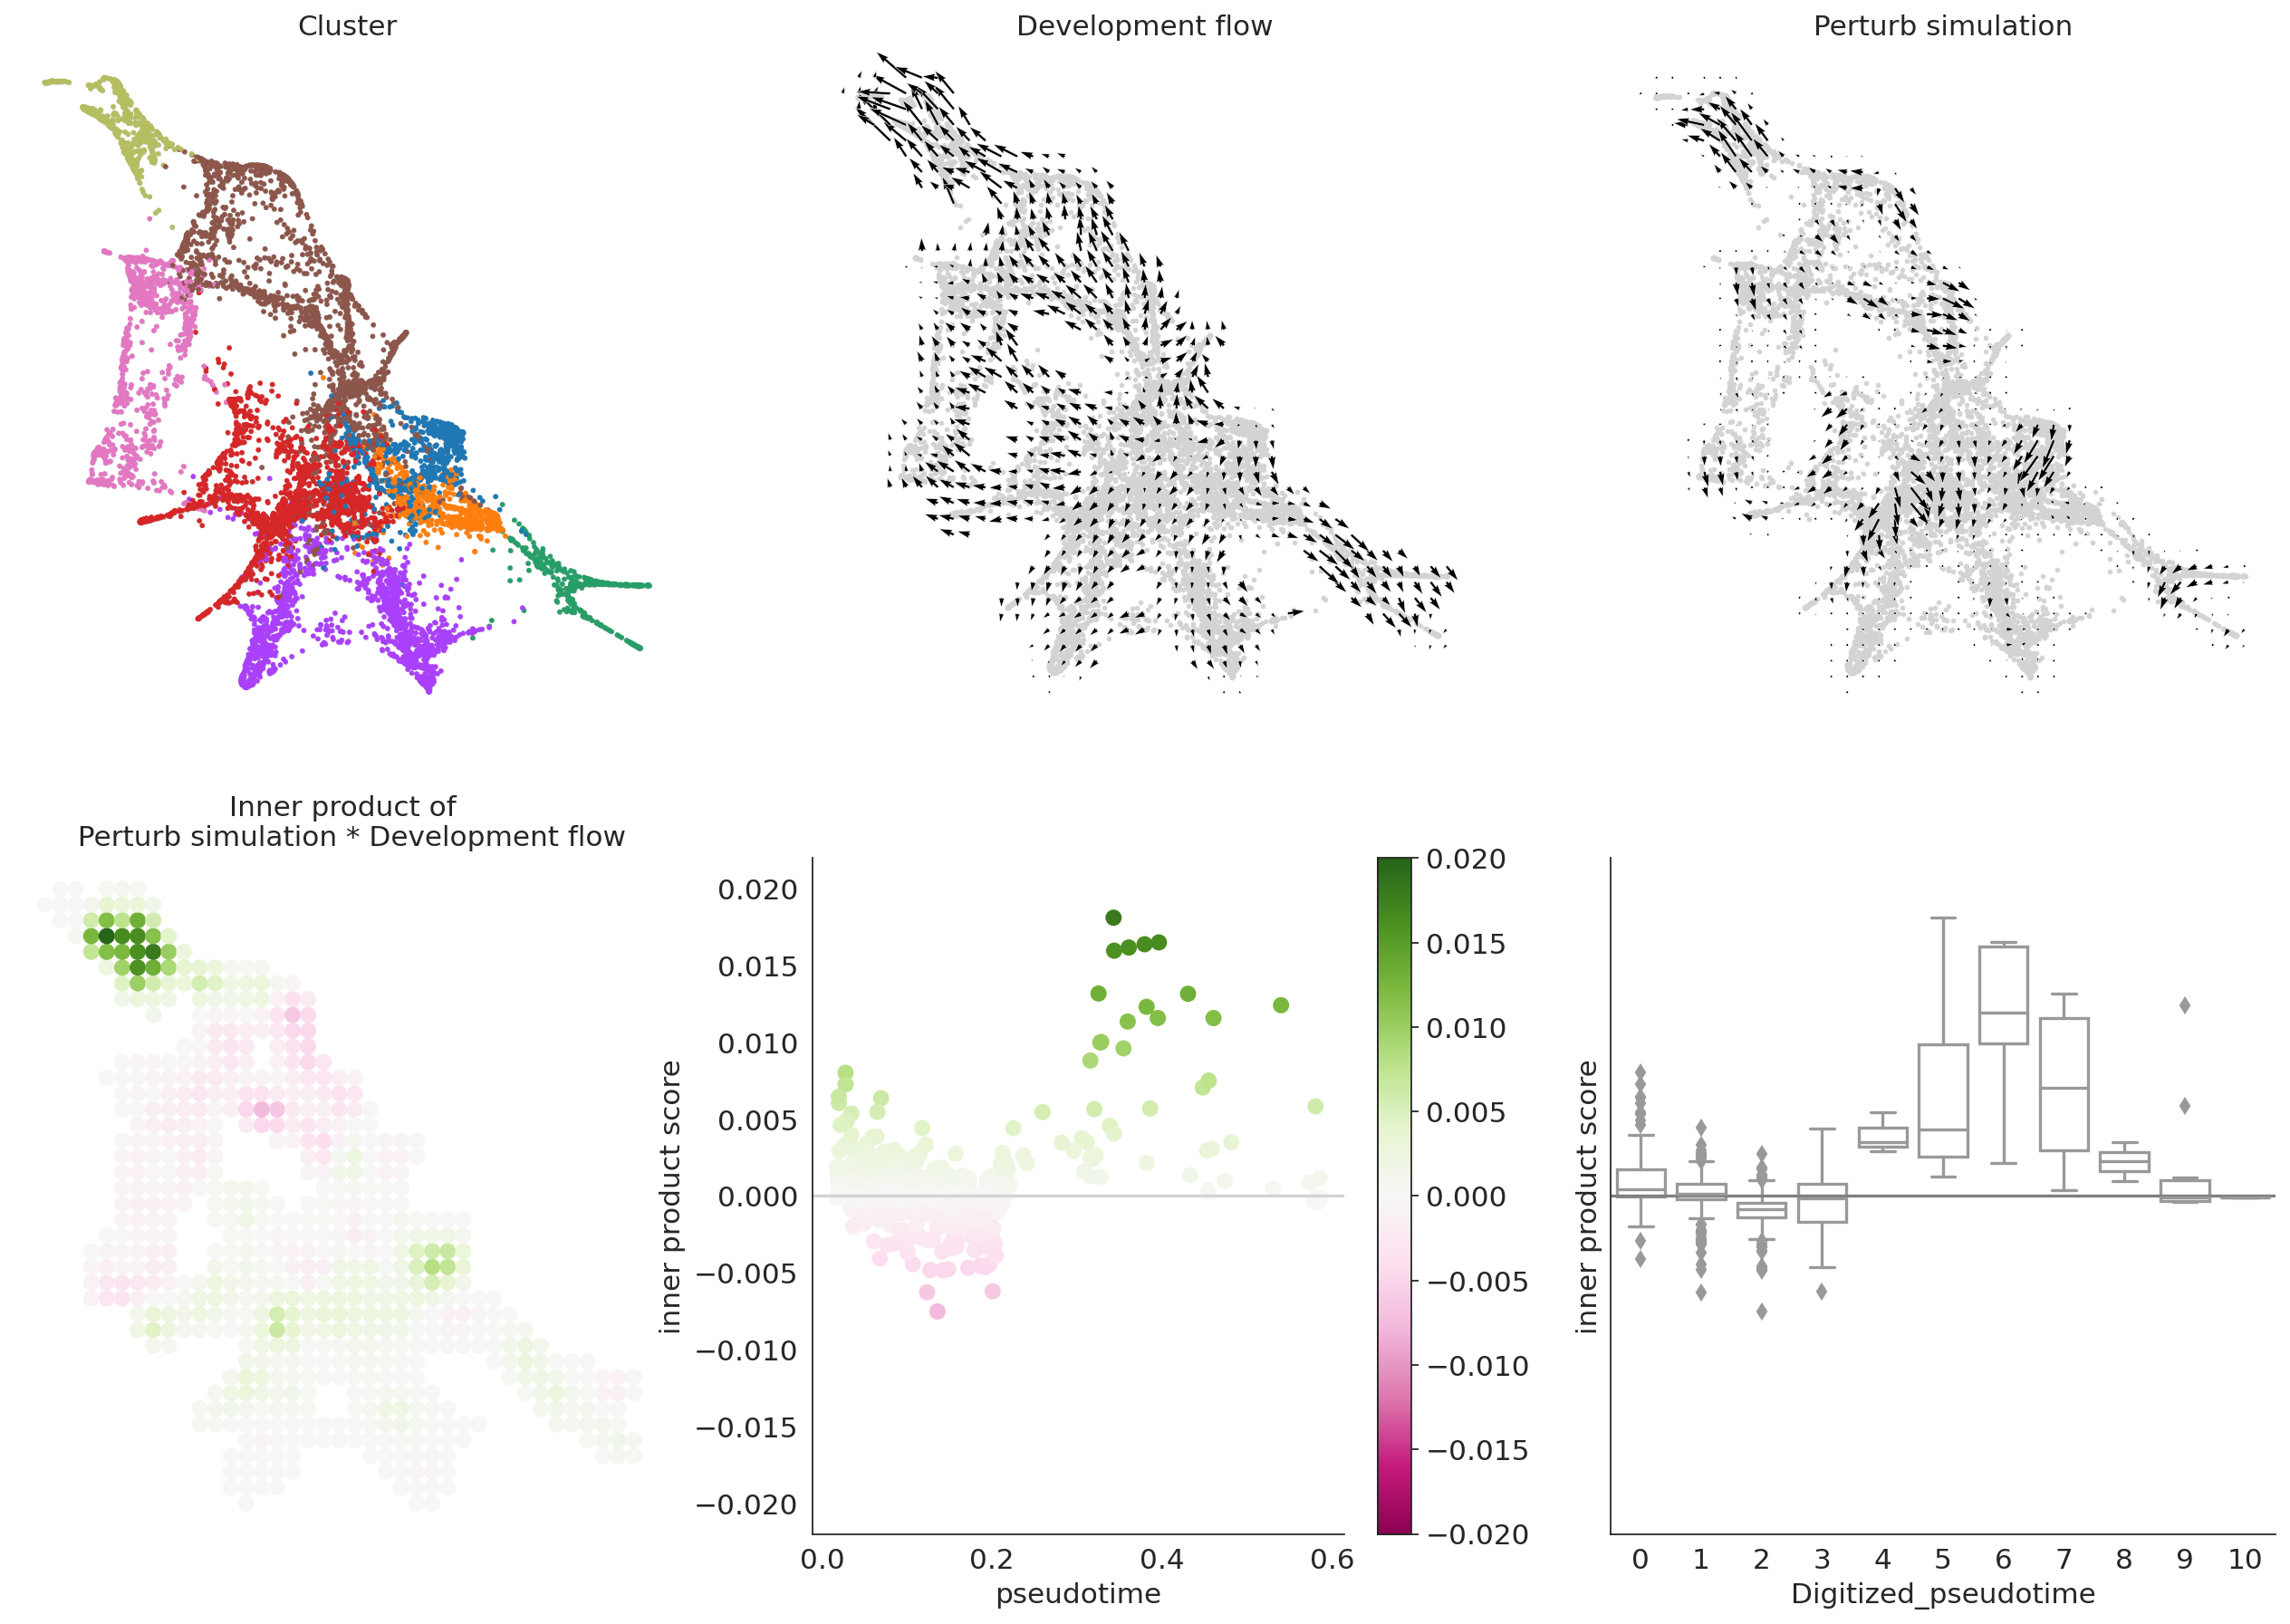

In [19]:
# Visualize result
dev.visualize_development_module_layout_0(s=5, scale_for_simulation=0.2, s_grid=50,
                                          scale_for_pseudotime=50, vm=0.02)

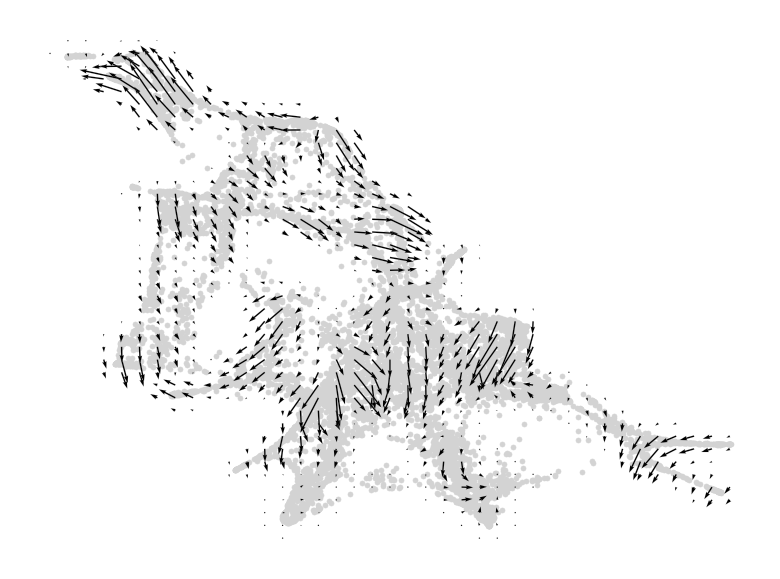

In [22]:
f = dev.plot_simulation_flow_on_grid(scale=0.15, args={'linewidth':0.05, 'width': 0.002})

In [23]:
f